In [1]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

### Preprocessing

In [2]:
def preprocess_audio(directory, max_length=100, mfcc_dim=24):
    labels = []
    features = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith(('.wav', '.mp3', '.flac')):
                    file_path = os.path.join(folder_path, file_name)
                    audio, sr = librosa.load(file_path)
                    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_dim)#MFCC implementation 
                    if mfcc.shape[1] > max_length:
                        mfcc = mfcc[:, :max_length]
                    else:
                        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant', constant_values=0)
                    features.append(mfcc.T)
                    labels.append(folder_name)
    features = np.array(features)
    labels = LabelEncoder().fit_transform(labels)
    return features, labels

path = 'wav_data/'  # Directory containing audio files organized in subfolders by class
X, y = preprocess_audio(path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

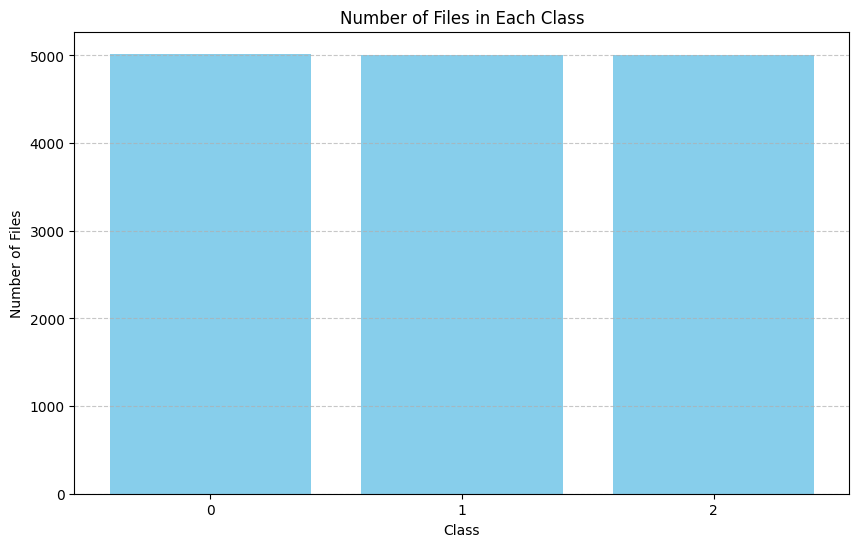

In [4]:
unique_classes, class_counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Class')
plt.xticks(unique_classes)  # Show all classes on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

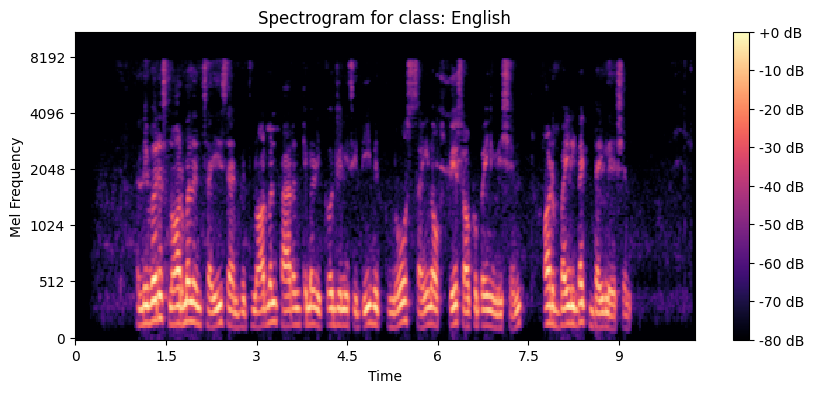

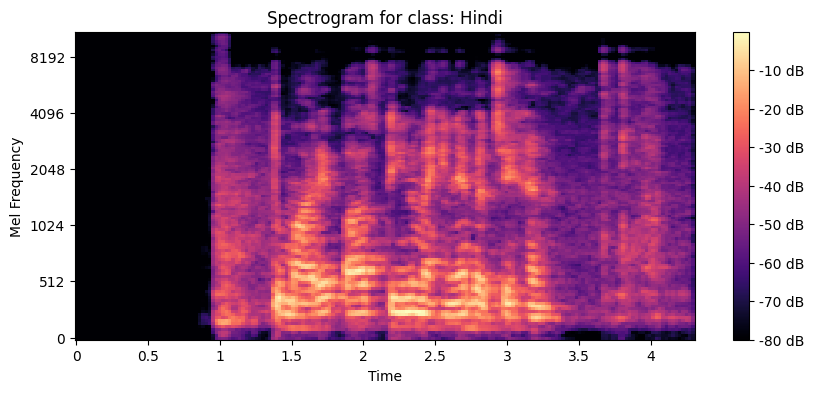

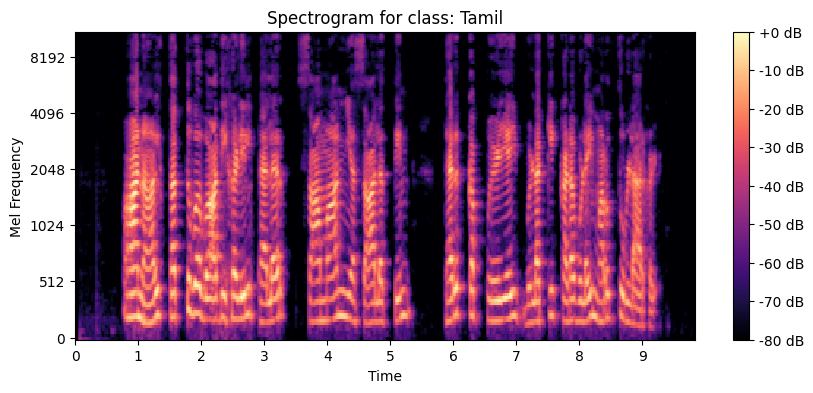

In [5]:
def plot_spectrogram(directory):
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            file_found = False
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith(('.wav', '.mp3', '.flac')):
                    file_path = os.path.join(folder_path, file_name)
                    audio, sr = librosa.load(file_path)
                    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
                    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
                    plt.figure(figsize=(10, 4))
                    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
                    plt.colorbar(format='%+2.0f dB')
                    plt.title('Spectrogram for class: {}'.format(folder_name))
                    plt.xlabel('Time')
                    plt.ylabel('Mel Frequency')
                    plt.show()
                    file_found = True
                    break
            if not file_found:
                print("No audio file found in folder:", folder_name)
plot_spectrogram(path)

### TDNN

In [6]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Activation, BatchNormalization
from tensorflow.keras.models import Model

# Assuming the preprocess_audio function is defined as you provided

def build_tdnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)  # Input layer
    
    # TDNN Layer 1
    x = Conv1D(filters=512, kernel_size=5, dilation_rate=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # TDNN Layer 2
    x = Conv1D(filters=512, kernel_size=3, dilation_rate=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # TDNN Layer 3
    x = Conv1D(filters=512, kernel_size=3, dilation_rate=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling1D()(x)  # Global average pooling to reduce dimensionality
    
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = X_train.shape[1:]  # Shape of the input data
num_classes = np.unique(y).shape[0]  # Number of unique classes

model = build_tdnn(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [7]:
# Training the model
history = model.fit(X_train, y_train,
                    epochs=10,  # You can adjust the number of epochs as needed
                    batch_size=64,  # Adjust batch size based on your system's capacity
                    validation_data=(X_test, y_test))  # Validation data to monitor performance during training

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 146s 748ms/step - accuracy: 0.8610 - loss: 0.3646 - val_accuracy: 0.8582 - val_loss: 0.4034
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 732ms/step - accuracy: 0.9404 - loss: 0.1692 - val_accuracy: 0.7926 - val_loss: 0.5578
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 139s 738ms/step - accuracy: 0.9526 - loss: 0.1371 - val_accuracy: 0.9391 - val_loss: 0.1702
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 137s 730ms/step - accuracy: 0.9580 - loss: 0.1226 - val_accuracy: 0.9368 - val_loss: 0.1840
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 732ms/step - accuracy: 0.9661 - loss: 0.0935 - val_accuracy: 0.9264 - val_loss: 0.2394
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 137s 731ms/step - accuracy: 0.9735 - loss: 0.0768 - val_accuracy: 0.8419 - val_loss: 0.5876
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 734ms/step - accuracy: 0.9692 - loss: 0.0873 - val_accuracy: 0.9674 - val_loss: 0.1075
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 735ms/step - accuracy: 0.9775 -

In [18]:
model.save("TDNN_FINAL.h5")

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 512)       │        61,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 512)       │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 512)       │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,924,427 (18.79 MB)

 Trainable params: 1,640,451 (6.26 MB)

 Non-trainable params: 3,072 (12.00 KB)

 Optimizer params: 3,280,904 (12.52 MB)

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step


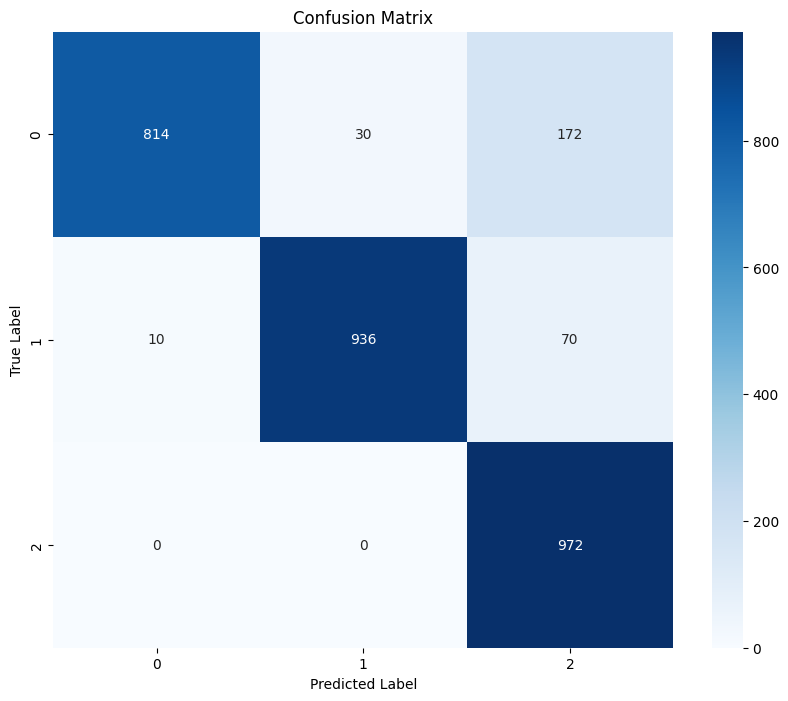

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [63]:
import sounddevice as sd
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load the saved model
model = load_model("TDNN_FINAL.h5")

# Define the function to predict live audio class
def predict_live_audio_class(model, label_encoder, max_length=100, num_mfcc=24):
    # Record live audio from the microphone
    duration = 5  # You can adjust the duration as needed
    print("Recording...")
    audio_data = sd.rec(int(duration * 44100), samplerate=44100, channels=1, dtype='float32')
    sd.wait()
    print("Recording stopped.")
    
    # Extract features (MFCCs)
    y = np.squeeze(audio_data)
    mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=num_mfcc)
    
    # Pad or truncate features to fixed length
    if mfccs.shape[1] < max_length:
        pad_width = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]
    
    # Reshape for LSTM input shape
    mfccs = mfccs.T.reshape(1, mfccs.shape[1], mfccs.shape[0])
    
    # Predict class probabilities
    predictions = model.predict(mfccs)
    
    # Get the predicted class label
    predicted_label_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_label_index]
    return predicted_label

# Define the classes used during training
classes = ["Tamil", "Hindi", "English"]  # Replace with your actual class names

# Create a LabelEncoder object and fit it to the classes
label_encoder = LabelEncoder()
label_encoder.fit(classes)

# Example usage:
predicted_class = predict_live_audio_class(model, label_encoder)
print("Predicted class:", predicted_class)

Recording...
Recording stopped.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Predicted class: Hindi


In [59]:
import numpy as np

def false_acceptance_rate_multiclass(conf_matrix, class_index):
    FP = np.sum(conf_matrix[:, class_index]) - conf_matrix[class_index, class_index]
    TN = np.sum(conf_matrix) - np.sum(conf_matrix[class_index, :]) - FP
    
    FAR = FP / (FP + TN)
    return FAR

# Example confusion matrix for multi-class classification
conf_matrix_multiclass = conf_matrix

num_classes = conf_matrix_multiclass.shape[0]

# Get false acceptance rate for each class
far_per_class = [false_acceptance_rate_multiclass(conf_matrix_multiclass, i) for i in range(num_classes)]

# Print false acceptance rate for each class
for i, far in enumerate(far_per_class):
    print(f'Class {i}: FAR = {far}')


Class 0: FAR = 0.005030181086519115
Class 1: FAR = 0.015090543259557344
Class 2: FAR = 0.11909448818897637


In [15]:
def missed_rate(conf_matrix):
    # Calculate False Negatives (FN) and True Positives (TP) for each class
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    
    # Calculate Missed Rate for each class
    missed_rate_per_class = FN / (FN + TP)
    return missed_rate_per_class

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Get missed rate for each class
missed_rate_per_class = missed_rate(conf_matrix)

# Print missed rate for each class
for i, class_name in enumerate(unique_classes):
    print(f'Class: {class_name}, Missed Rate: {missed_rate_per_class[i]}')

Class: 0, Missed Rate: 0.19881889763779528
Class: 1, Missed Rate: 0.07874015748031496
Class: 2, Missed Rate: 0.0


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test, y_pred_classes, average=None)
recall_per_class = recall_score(y_test, y_pred_classes, average=None)
f1_score_per_class = f1_score(y_test, y_pred_classes, average=None)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Calculate macro/micro average precision, recall, and F1 score
macro_precision = precision_score(y_test, y_pred_classes, average='macro')
macro_recall = recall_score(y_test, y_pred_classes, average='macro')
macro_f1_score = f1_score(y_test, y_pred_classes, average='macro')

micro_precision = precision_score(y_test, y_pred_classes, average='micro')
micro_recall = recall_score(y_test, y_pred_classes, average='micro')
micro_f1_score = f1_score(y_test, y_pred_classes, average='micro')

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1 Score per class:", f1_score_per_class)
print("Accuracy:", accuracy)
print("Macro Average Precision:", macro_precision)
print("Macro Average Recall:", macro_recall)
print("Macro Average F1 Score:", macro_f1_score)
print("Micro Average Precision:", micro_precision)
print("Micro Average Recall:", micro_recall)
print("Micro Average F1 Score:", micro_f1_score)

Precision per class: [0.98786408 0.9689441  0.80065898]
Recall per class: [0.8011811  0.92125984 1.        ]
F1 Score per class: [0.88478261 0.9445005  0.88929552]
Accuracy: 0.9061251664447404
Macro Average Precision: 0.9191557185439937
Macro Average Recall: 0.90748031496063
Macro Average F1 Score: 0.906192876720804
Micro Average Precision: 0.9061251664447404
Micro Average Recall: 0.9061251664447404
Micro Average F1 Score: 0.9061251664447404


In [17]:
import pandas as pd

# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test, y_pred_classes, average=None)
recall_per_class = recall_score(y_test, y_pred_classes, average=None)
f1_score_per_class = f1_score(y_test, y_pred_classes, average=None)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Calculate macro/micro average precision, recall, and F1 score
macro_precision = precision_score(y_test, y_pred_classes, average='macro')
macro_recall = recall_score(y_test, y_pred_classes, average='macro')
macro_f1_score = f1_score(y_test, y_pred_classes, average='macro')

micro_precision = precision_score(y_test, y_pred_classes, average='micro')
micro_recall = recall_score(y_test, y_pred_classes, average='micro')
micro_f1_score = f1_score(y_test, y_pred_classes, average='micro')

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Class': unique_classes,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_score_per_class
})

# Add rows for overall metrics
overall_metrics = pd.DataFrame({
    'Class': ['Overall'],
    'Precision': [macro_precision],
    'Recall': [macro_recall],
    'F1 Score': [macro_f1_score]
})

metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)

# Add accuracy
metrics_df.loc[len(metrics_df)] = ['Accuracy', '', '', accuracy]

# Display the DataFrame
print(metrics_df)

      Class Precision    Recall  F1 Score
0         0  0.987864  0.801181  0.884783
1         1  0.968944   0.92126  0.944501
2         2  0.800659       1.0  0.889296
3   Overall  0.919156   0.90748  0.906193
4  Accuracy                      0.906125


### Testing

In [12]:
def extract_features_from_file(file_path, max_length=100, mfcc_dim=24):
    audio, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=mfcc_dim)
    if mfcc.shape[1] > max_length:
        mfcc = mfcc[:, :max_length]
    else:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant', constant_values=0)
    return mfcc.T[24,100]  


In [29]:
# Path to your MP3 file
file_path = r"D:\PROJECT\SEM-6\SPEECH\DATA\TAMIL\common_voice_ta_32862636.mp3"

# Extract features
features = extract_features_from_file(file_path)

# Make a prediction
prediction = model.predict(features)
predicted_class = np.argmax(prediction, axis=1)

# Assuming you have a way to map from predicted class indices back to class labels
class_labels = LabelEncoder().inverse_transform(predicted_class)
print(f'Predicted class: {class_labels[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted class: Tamil


In [32]:
import sounddevice as sd
import numpy as np
import librosa

def predict_live_audio_class(model, max_length=100):
    # Record live audio from the microphone
    duration = 5  # You can adjust the duration as needed
    print("Recording...")
    audio_data = sd.rec(int(duration * 44100), samplerate=44100, channels=1, dtype='float32')
    sd.wait()
    print("Recording stopped.")
    
    # Extract features (MFCCs)
    y = np.squeeze(audio_data)
    mfccs = librosa.feature.mfcc(y=y, sr=44100)
    
    # Pad or truncate features to fixed length
    if mfccs.shape[1] < max_length:
        pad_width = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]
    
    # Reshape for LSTM input shape
    mfccs = mfccs.T.reshape(1, mfccs.shape[1], mfccs.shape[0])
    
    # Predict class probabilities
    predictions = model.predict(mfccs)
    
    # Get the predicted class label
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
    return predicted_label[0]

# Example usage:
predicted_class = predict_live_audio_class(model)
print("Predicted class:", predicted_class)


Recording...
Recording stopped.
Predicted class: Hindi


In [38]:
import numpy as np
import librosa

def predict_audio_file_class(model, audio_file, max_length=100):
    try:
        # Load audio file
        y, sr = librosa.load(audio_file, sr=44100)
    except Exception as e:
        print("Error loading audio file:", e)
        return None
    
    # Calculate the total number of frames
    total_frames = int(np.ceil(len(y) / sr))
    
    # Initialize list to store predicted classes
    predicted_classes = []
    
    # Process each second separately
    for i in range(total_frames):
        # Extract audio for the current second
        audio_segment = y[i * sr : (i + 1) * sr]
        
        # Extract features (MFCCs)
        mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr)
        
        # Pad or truncate features to fixed length
        if mfccs.shape[1] < max_length:
            pad_width = max_length - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_length]
        
        # Reshape for LSTM input shape
        mfccs = mfccs.T.reshape(1, mfccs.shape[1], mfccs.shape[0])
        
        # Predict class probabilities
        predictions = model.predict(mfccs)
        
        # Get the predicted class label
        predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
        
        # Append predicted class to the list
        predicted_classes.append(predicted_label[0])
    
    return predicted_classes

# Example usage:
audio_file = "test.m4a"  # Provide the path to your audio file
predicted_classes = predict_audio_file_class(model, audio_file)
print("Predicted classes for each second:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted classes for each second: ['Hindi', 'English', 'Hindi', 'Hindi', 'English', 'Hindi', 'Hindi', 'English', 'Hindi', 'Hindi', 'Hindi', 'Hindi']


In [75]:
import numpy as np
import librosa

def predict_audio_file_class(model, audio_file, max_length=100):
    try:
        # Load audio file
        y, sr = librosa.load(audio_file, sr=44100)
    except Exception as e:
        print("Error loading audio file:", e)
        return None
    
    # Calculate the total number of frames
    total_frames = int(np.ceil(len(y) / sr))
    
    # Initialize list to store predicted classes
    predicted_classes = []
    
    # Process each second separately
    for i in range(total_frames):
        # Extract audio for the current second
        audio_segment = y[i * sr : (i + 1) * sr]
        
        # Extract features (MFCCs)
        mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr)
        
        # Pad or truncate features to fixed length
        if mfccs.shape[1] < max_length:
            pad_width = max_length - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_length]
        
        # Reshape for LSTM input shape
        mfccs = mfccs.T.reshape(1, mfccs.shape[1], mfccs.shape[0])
        
        # Predict class probabilities
        predictions = model.predict(mfccs)
        
        # Get the predicted class label
        predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
        
        # Append predicted class to the list
        predicted_classes.append(predicted_label[0])
    
    return predicted_classes

# Example usage:
audio_file = "test.wav"  # Provide the path to your audio file
predicted_classes = predict_audio_file_class(model, audio_file)
print("Predicted classes for each second:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted classes for each second: ['Hindi', 'English', 'English', 'English', 'English', 'Tamil', 'Tamil', 'English', 'English', 'English', 'Hindi', 'Tamil']

